In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import Resize, ToTensor, Compose, Grayscale
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [2]:
BENIGN_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"
MALIGNANT_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
NORMAL_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal"


benign_images = []
normal_images = []
malign_images = []
for i in os.listdir(BENIGN_PATH):
    if "mask" not in i: 
        benign_images.append((Image.open(BENIGN_PATH + "/" + i), 0))
for i in os.listdir(NORMAL_PATH):
    if "mask" not in i:
        normal_images.append((Image.open(NORMAL_PATH + "/" + i), 2))
for i in os.listdir(MALIGNANT_PATH):
    if "mask" not in i:
        malign_images.append((Image.open(MALIGNANT_PATH + "/" + i), 1))

In [3]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel

In [4]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained('emre570/google-vit-large-finetuned',attn_implementation="eager")

# references used to fix the issue with vit not outputting attentions:
# https://github.com/huggingface/transformers/issues/30978
# https://datascience.stackexchange.com/questions/129353/attentions-not-returned-from-transformers-vit-model-when-using-output-attentions

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

In [ ]:
from typing import Iterable
# Resize is torchvision.transforms.Resize. Import it as from torchvision.transforms import Resize
def raw_attention_map(attentions:Iterable[torch.Tensor], layer:int = -1, size:tuple[int] = (224,224)) -> np.ndarray:
    avg_attention = attentions[layer].mean(dim=1).squeeze(0).detach().numpy()
    # We need attention from Cls token to all other tokens, which is obtained from the first row of the attention matrix. So here we will use the first layer
    # of the avg_attention matrix. Also since we only need attentions from cls token to patch tokens, we will also ignore the first element of the first row which is
    # just attention from class token to class token
    cls_attention = avg_attention[0, 1:]
    cls_attention = cls_attention.reshape(int(np.sqrt(cls_attention.shape[0])), int(np.sqrt(cls_attention.shape[0])))
    resize = Resize(size)
    cls_attention = resize(torch.tensor(cls_attention).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()
    cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
    return cls_attention

# Image.Image is PIL.Image.Image, just incase if you face import errors @dhruv
def raw_attention_heatmap(attentions:Iterable[torch.Tensor], image: Image.Image, layer:int = -1, size:tuple[int] = (224,224)) -> None:
    attention_map = raw_attention_map(attentions, layer, size)
    resize = Resize(size)
    image = resize(image)
    plt.imshow(image)
    plt.imshow(attention_map, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Attention Intensity')
    plt.show()

def get_rawheat_maps_from_model(feature_extractor, model, image: Image.Image, layer:int = -1, size:tuple[int] = (224, 224)) -> None:
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True, return_dict=True)
    attentions = outputs.attentions
    print("output class probabilities:")
    print(nn.functional.softmax(outputs.logits[0], dim=0).detach().numpy())
    raw_attention_heatmap(attentions, image, layer, size)

def raw_heatmaps_all_layer(feature_extractor, model, image: Image.Image, size:tuple[int] = (224, 224)) -> None:
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True, return_dict=True)
    attentions = outputs.attentions
    print("output class probabilities:")
    print(nn.functional.softmax(outputs.logits[0], dim=0).detach().numpy())
    
    resize = Resize(size)
    image = resize(image)
    plt.imshow(image)
    plt.title("original image")
    plt.show()
    for layer in range(len(attentions)):
        attention_map = raw_attention_map(attentions, layer, size)
        plt.imshow(image)
        plt.imshow(attention_map, cmap='viridis', alpha=0.5)
        plt.title(f"layer: {layer+1}")
        plt.show()
    plt.show()

#####

In [6]:
# Resize is torchvision.transforms.Resize. Import it as from torchvision.transforms import Resize
def rolling_attention_map(attentions:Iterable[torch.Tensor], size:tuple[int] = (224,224), layers:int|None = None) -> np.ndarray:
    rolling_attention = torch.eye(attentions[0].shape[-1]).to(attentions[0].device) # shape: tokens, tokens
    if layers == None:
        layers = len(attentions)
    for idx, attention in enumerate(attentions):
        if idx == layers:
            break
        avg_attention = attention.mean(dim=1).squeeze(0) # shape: tokens, tokens
        avg_attention += torch.eye(avg_attention.shape[-1]) # shape: tokens, tokens
        avg_attention /= avg_attention.sum() # normalization
        rolling_attention = rolling_attention @ avg_attention
        # rolling_attention = avg_attention @ rolling_attention
        
    rolling_attention = rolling_attention.detach().numpy()
    cls_attention = rolling_attention[0, 1:]
    cls_attention = cls_attention.reshape(int(np.sqrt(cls_attention.shape[0])), int(np.sqrt(cls_attention.shape[0])))
    resize = Resize(size)
    cls_attention = resize(torch.tensor(cls_attention).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()
    cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
    return cls_attention

# Image.Image is PIL.Image.Image, just incase if you face import errors @dhruv
def rolling_attention_heatmap(attentions:Iterable[torch.Tensor], image: Image.Image, size:tuple[int] = (224,224), layers=None) -> None:
    attention_map = rolling_attention_map(attentions=attentions, size=size, layers=layers)
    resize = Resize(size)
    image = resize(image)
    plt.imshow(image)
    plt.imshow(attention_map, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Attention Intensity')
    plt.show()

def get_rolling_heatmaps_from_model(feature_extractor, model, image: Image.Image, size:tuple[int] = (224, 224), layers=None) -> None:
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True, return_dict=True)
    attentions = outputs.attentions
    print("output class probabilities:")
    print(nn.functional.softmax(outputs.logits[0], dim=0).detach().numpy())
    rolling_attention_heatmap(attentions=attentions, image=image, size=size, layers=layers)

def rolling_heatmaps_all_layer(feature_extractor, model, image: Image.Image, size:tuple[int] = (224, 224)) -> None:
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True, return_dict=True)
    attentions = outputs.attentions
    print("output class probabilities:")
    print(nn.functional.softmax(outputs.logits[0], dim=0).detach().numpy())
    
    resize = Resize(size)
    image = resize(image)
    plt.imshow(image)
    plt.title("original image")
    plt.show()
    for layer in range(len(attentions)):
        attention_map = rolling_attention_map(attentions, size, layer+1)
        plt.imshow(image)
        plt.imshow(attention_map, cmap='viridis', alpha=0.5)
        plt.title(f"layer: {layer+1}")
        plt.show()
    plt.show()

In [7]:
idx = 1
# image, label = benign_images[idx]
# image, label = normal_images[idx]
image, label = malign_images[idx]

print("correct label:", label)

correct label: 1


output class probabilities:
[1.3376120e-04 9.9986279e-01 3.4088225e-06]


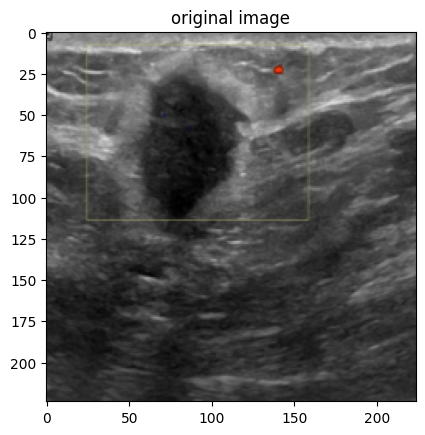

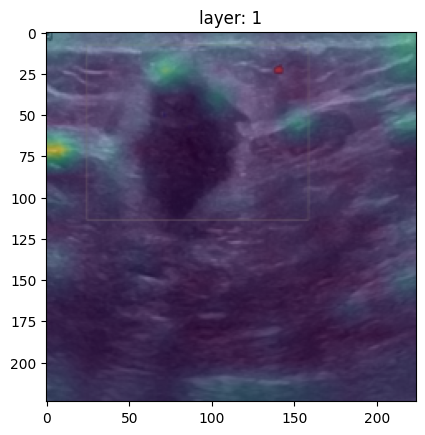

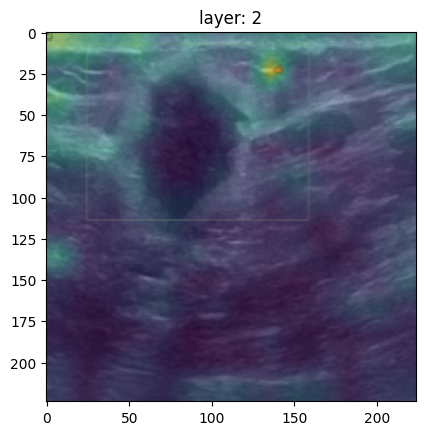

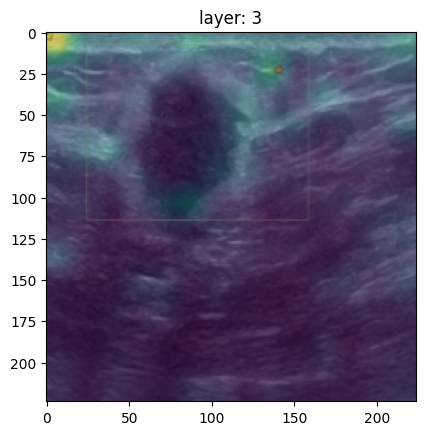

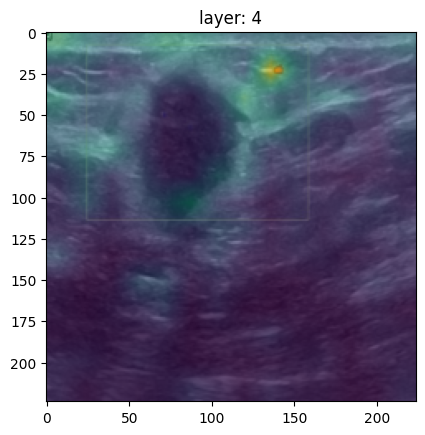

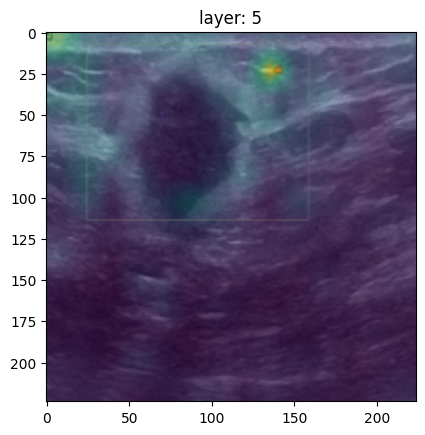

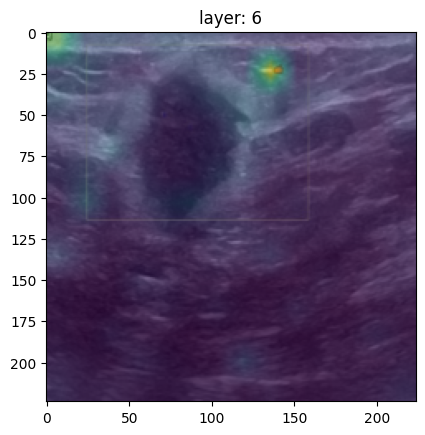

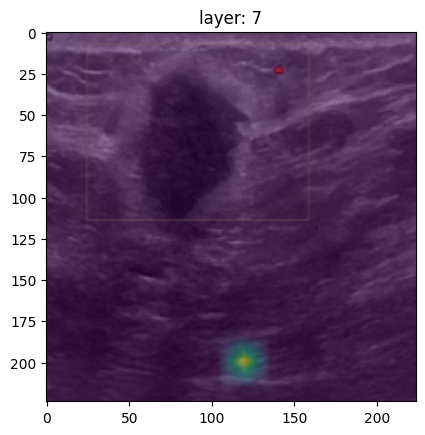

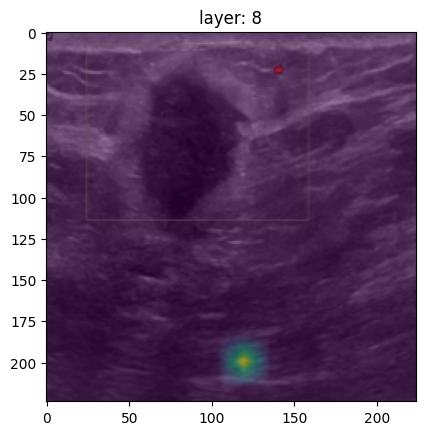

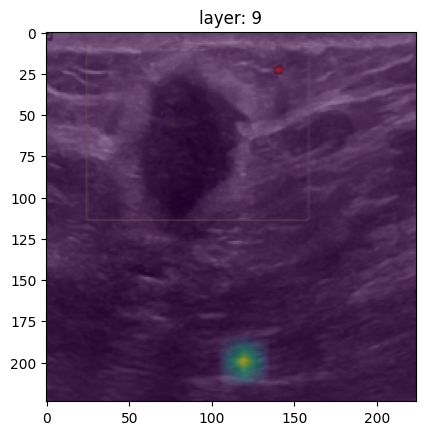

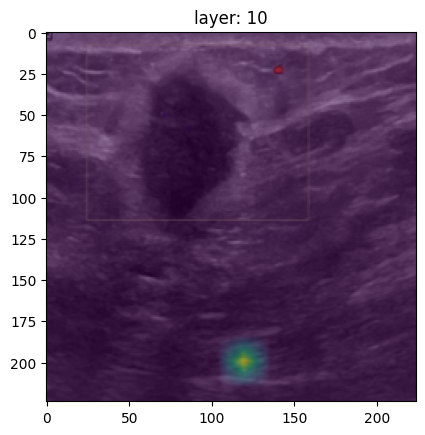

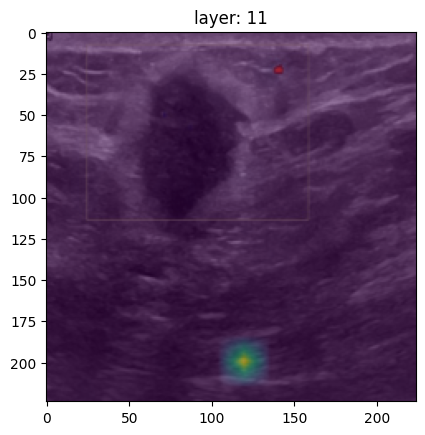

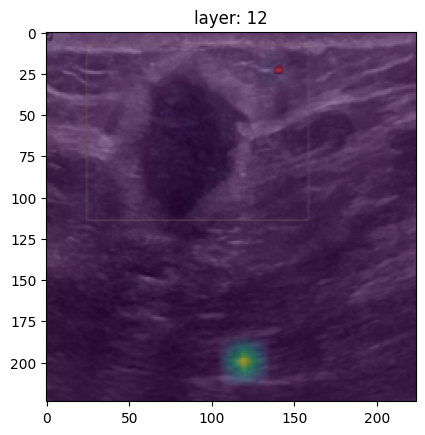

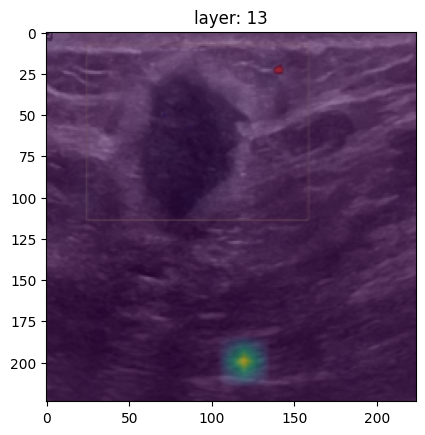

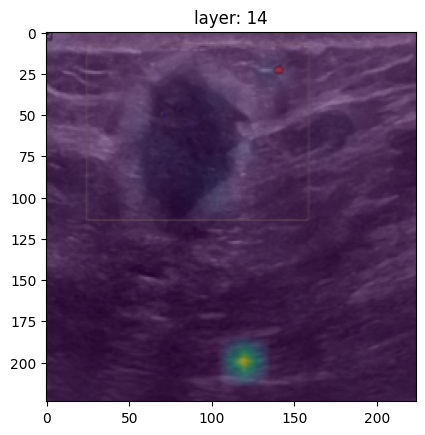

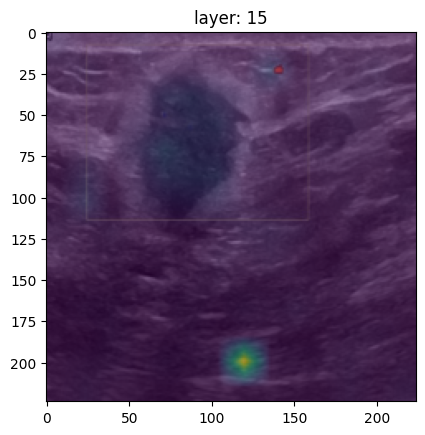

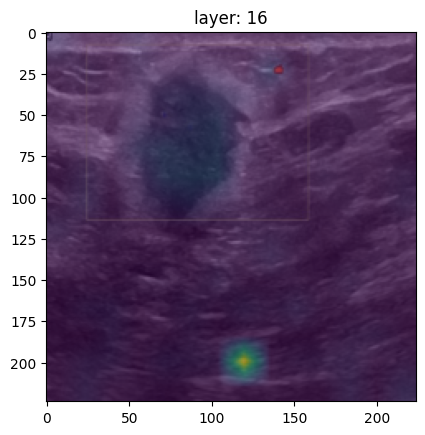

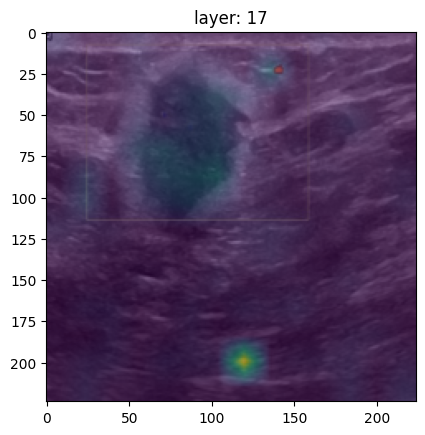

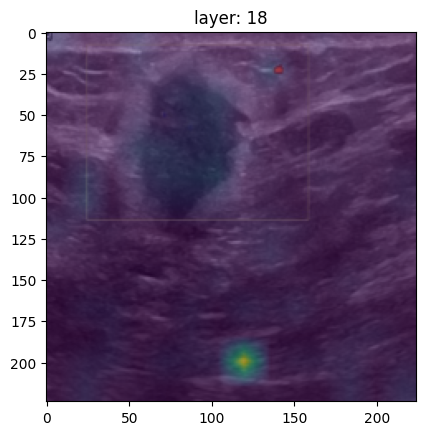

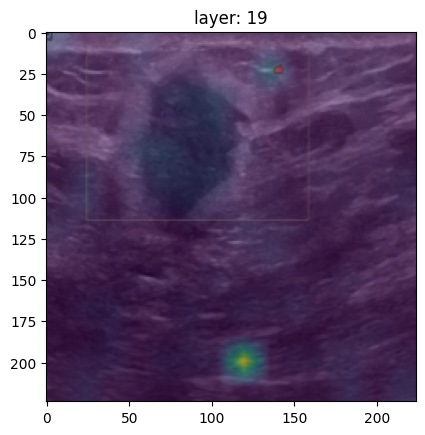

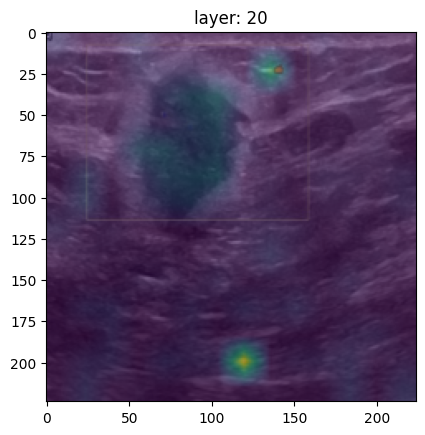

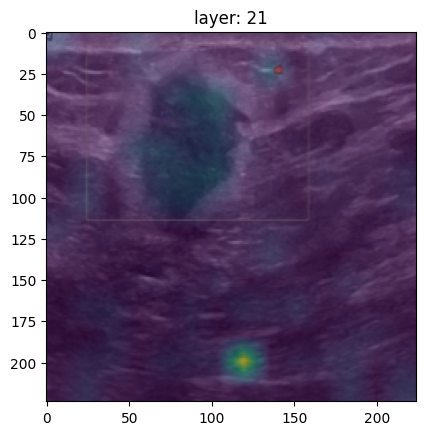

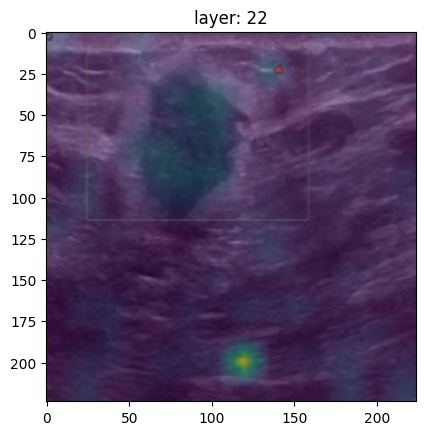

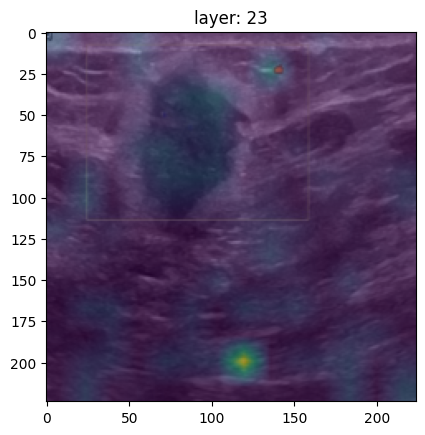

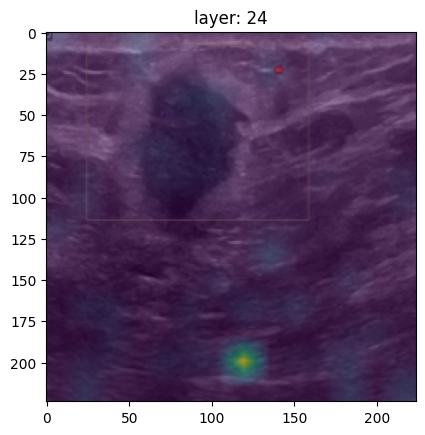

In [8]:
# raw attention maps
raw_heatmaps_all_layer(feature_extractor, model, image)

output class probabilities:
[1.3376120e-04 9.9986279e-01 3.4088225e-06]


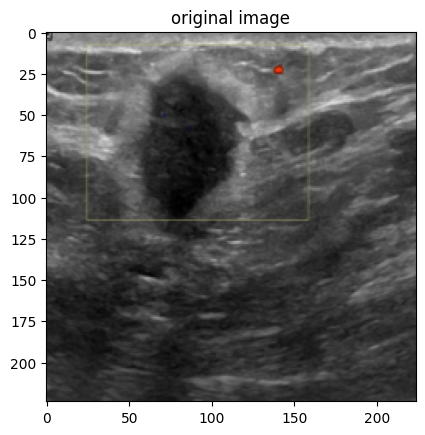

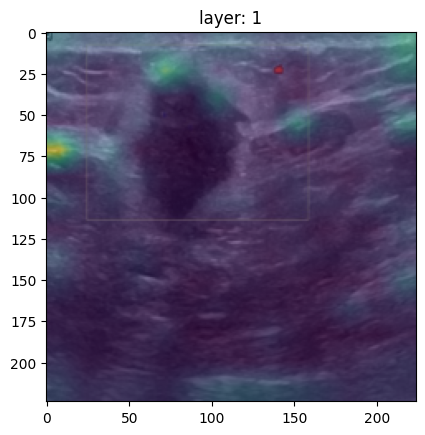

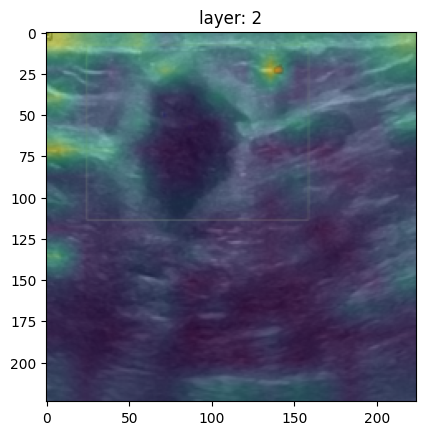

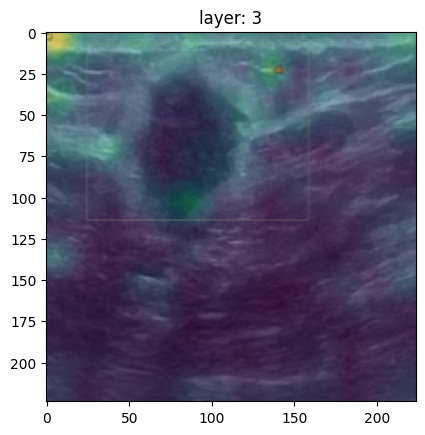

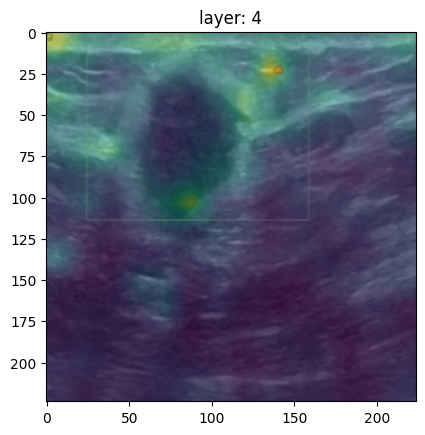

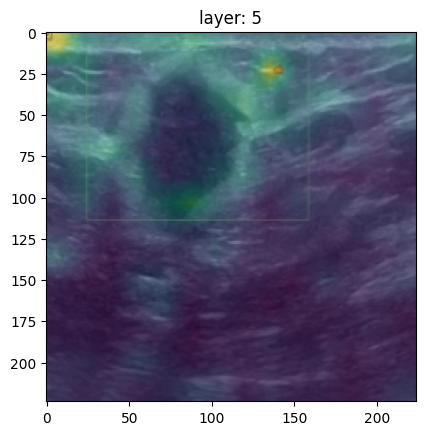

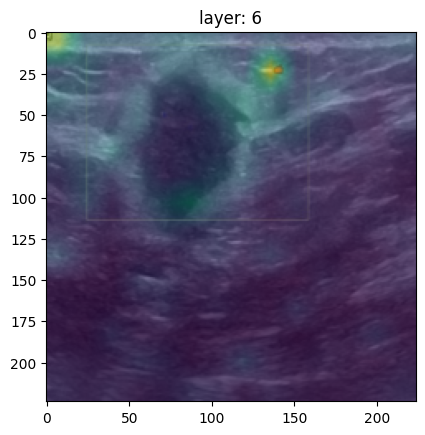

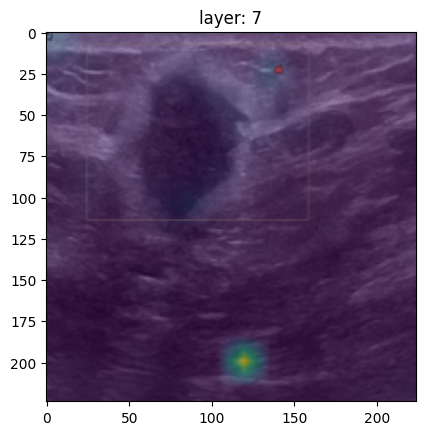

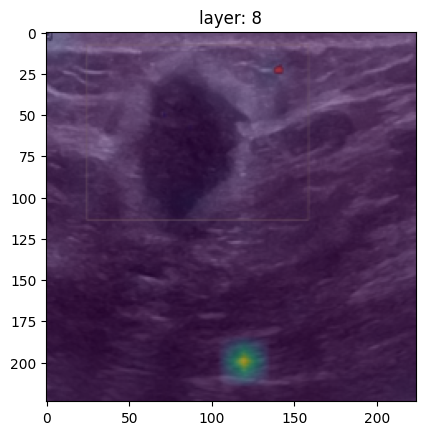

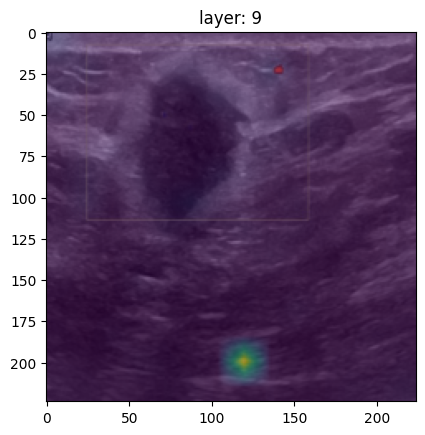

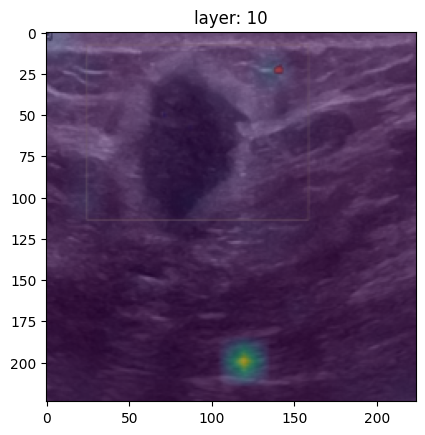

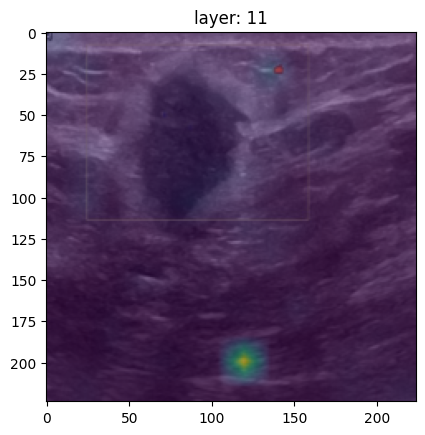

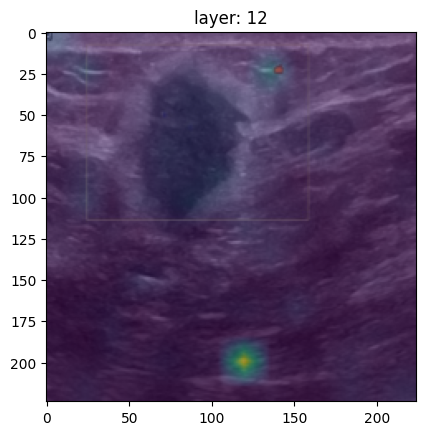

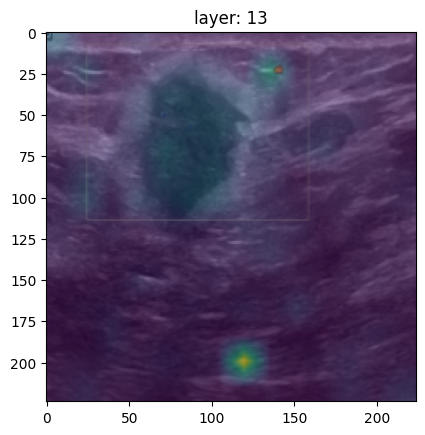

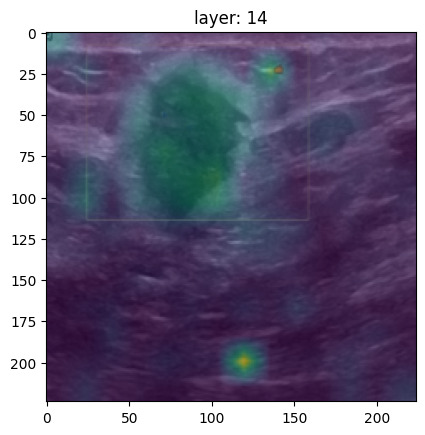

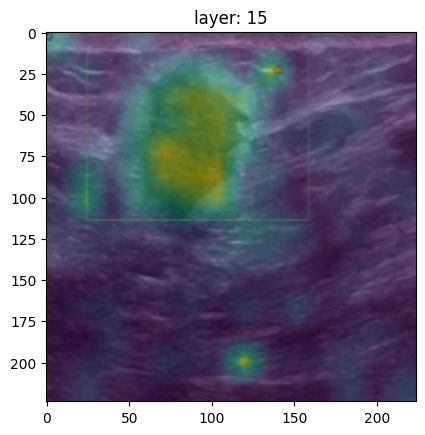

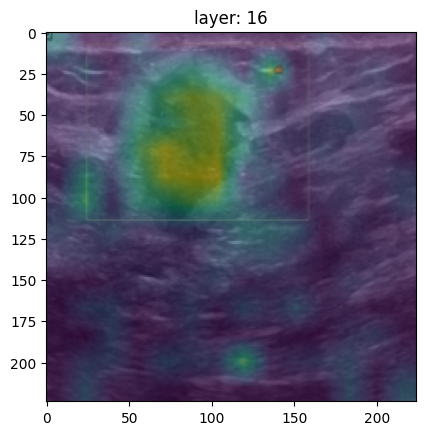

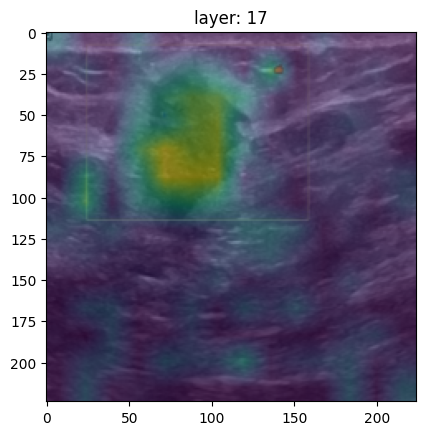

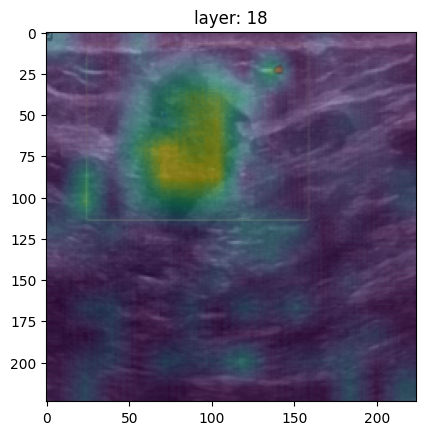

/tmp/ipykernel_30/3113843517.py:20: RuntimeWarning: invalid value encountered in divide
  cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())


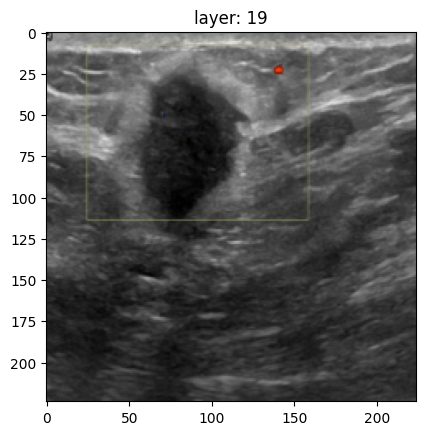

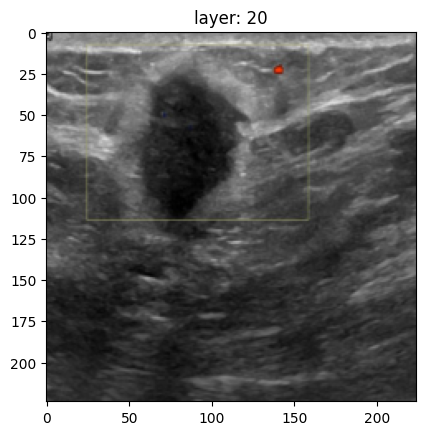

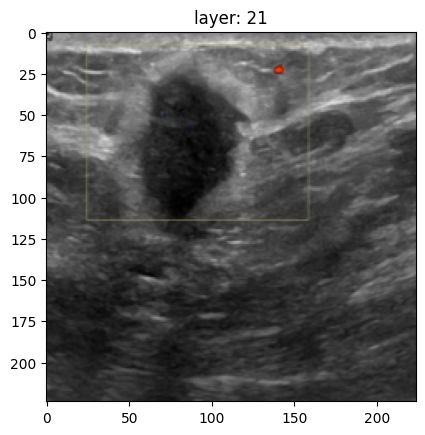

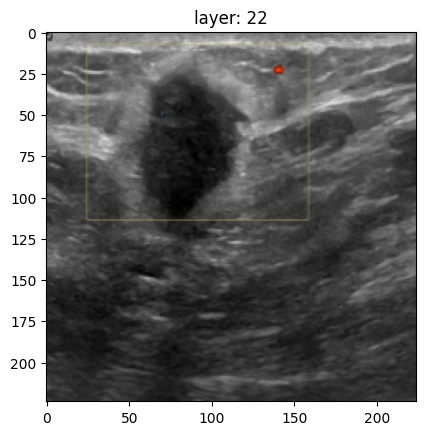

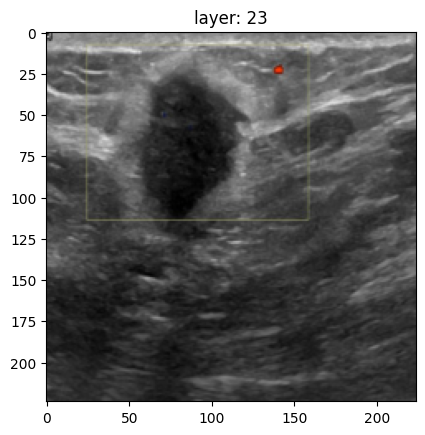

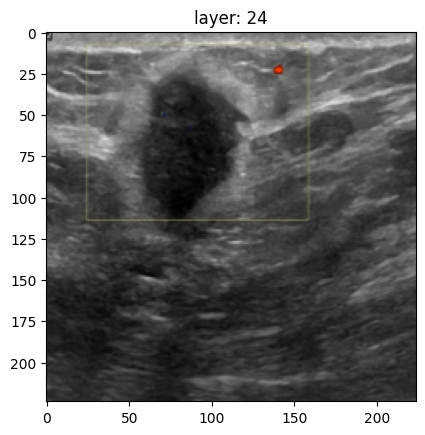

In [9]:
# rolling attention maps
rolling_heatmaps_all_layer(feature_extractor, model, image)